## 概述
神经网络文本摘要

In [1]:
from collections import Counter
import re
from datetime import datetime

import jieba
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # 1.0.1
from tensorflow.python.ops import variable_scope

%matplotlib inline
# %load_ext watermark
# %watermark -p tensorflow,numpy -v -m

In [2]:
# 模型相关参数
cell_size = 100
num_layers = 2  # rnn cell 层数
embedding_size = 100
buckets = [(30, 14), (40, 14), (50, 14)]
num_sampled = 1000

# 语料读取参数
lines_to_read_train = 110000  # 取0表示读取整个文件
lines_to_read_dev = 9000  # 取0表示读取整个文件
vocab_min_freq_enc = 3  # 计入词表的最小词频, 小于此值则记为 UNK
vocab_min_freq_dec = 2  # 计入词表的最小词频, 小于此值则记为 UNK

## 读入语料并处理

In [3]:
basedir = '^data/'
files = {'train': {'from': basedir + 'train_contents.txt',
                   'to': basedir + 'train_titles.txt'},
         'dev': {'from': basedir + 'dev_contents.txt',
                  'to': basedir + 'dev_titles.txt'}}

### 文本预处理

见 `data.ipynb`

### 读取文本文件, tokenize 得到 sentences (word lists)

decoder inputs 在句子首尾分别添加特殊 token
* 句首的 <GO> Token 是为了喂给 decoder 的第一个 cell, 以便生成第一个词.  
* 句末的 <EOS> Token 相当于人为给模型提供一个句子结束的信号, 让模型自己学会何时结束句子.

In [4]:
_PAD, _GO, _EOS, _UNK = '<PAD>', '<GO>', '<EOS>', '<UNK>' 
_PAD_ID, _GO_ID, _EOS_ID, _UNK_ID = 0, 1, 2, 3
_START_VOCAB = (_PAD, _GO, _EOS, _UNK)

In [5]:
def en_tokenizer(sentence):
    """英文句子分词
    source: https://github.com/tensorflow/models/blob/master/tutorials/rnn/translate/data_utils.py
    """
    _word_split = re.compile("([.,!?\"':;)(])")
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(_word_split.split(space_separated_fragment))
    return [w for w in words if w]

def zh_tokenizer(sentence):
    '''中文句子分词'''
    return [w for w in jieba.cut(sentence.strip()) 
            if w not in (' ', '\t', '\n',)]
    # return [char for char in sentence.strip() if char not in (' ', '\t', '\n')]


def read_sentences(encoder_file, decoder_file, lines_to_read=None):
    """默认从英文到中文"""
    
    # 读取文件. lines_to_read 参数可用于小规模试验.
    with open(encoder_file, encoding='utf-8') as f:
        enc_lines = f.readlines()[:lines_to_read] if lines_to_read else f.readlines()
    with open(decoder_file, encoding='utf-8') as f:
        dec_lines = f.readlines()[:lines_to_read] if lines_to_read else f.readlines()
    assert len(enc_lines) == len(dec_lines)

    num_lines = len(enc_lines)
    
    encoder_sentences = []
    decoder_sentences = []
    
    for i in range(num_lines):
        enc_sentence = zh_tokenizer(enc_lines[i])
        dec_sentence = zh_tokenizer(dec_lines[i])
        if enc_sentence and dec_sentence:
            encoder_sentences.append(enc_sentence)
            decoder_sentences.append(dec_sentence)
    return encoder_sentences, decoder_sentences


encoder_sentences, decoder_sentences = read_sentences(
    files['train']['from'], files['train']['to'], lines_to_read=lines_to_read_train)
encoder_sentences_test, decoder_sentences_test = read_sentences(
    files['dev']['from'], files['dev']['to'], lines_to_read=lines_to_read_dev)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.835 seconds.
Prefix dict has been built succesfully.


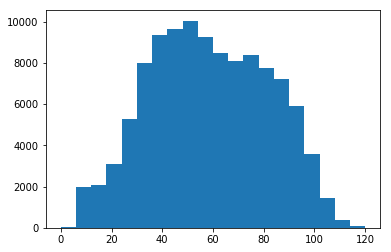

In [6]:
def plot_length_histogram(sentences):
    lengths = np.asarray([len(s) for s in sentences])
    max_len = np.max(lengths)
    plt.hist(lengths, bins=range(0, max_len, int(max_len/20) or 1));

plot_length_histogram(encoder_sentences)

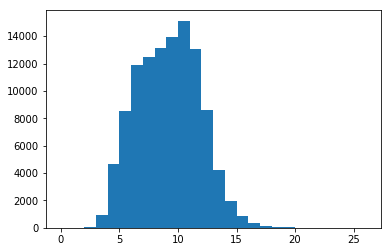

In [7]:
plot_length_histogram(decoder_sentences)

### 由训练文件的 word lists 得到 vocab

In [9]:
def build_vocab(sentences, vocab_min_freq):
    """生成词表. 前几个位置留给 _START_VOCAB 的特殊 token """
    vocab = list(_START_VOCAB)
    words_flat = [w for s in sentences for w in s]
    word_cnt = Counter(words_flat)
    for word, count in word_cnt.most_common():
        if count >= vocab_min_freq:
            vocab.append(word)
    return vocab

# vocab_xxx 相当于 demo 代码里的 reversed_vocab
vocab_enc = build_vocab(encoder_sentences, vocab_min_freq_enc)  # list: id -> word
vocab_dec = build_vocab(decoder_sentences, vocab_min_freq_dec)
num_encoder_symbols = len(vocab_enc)
num_decoder_symbols = len(vocab_dec)

# wod2id_xxx 相当于 demo 代码里的 vocab
word2id_enc = {w: i for i, w in enumerate(vocab_enc)}  # dict: word -> id
word2id_dec = {w: i for i, w in enumerate(vocab_dec)}

print(num_encoder_symbols, num_decoder_symbols)

80030 44907


### decoder inputs 句子首尾加 token

In [10]:
def add_tokens(sentences):
    """为 decoder 的输入语句增加首尾 token"""
    for i in range(len(sentences)):
        sentences[i] = [_GO] + sentences[i] + [_EOS]
    return sentences

decoder_sentences = add_tokens(decoder_sentences)
decoder_sentences_test = add_tokens(decoder_sentences_test)

### tokens -> ids -> bucketing -> padding

In [13]:
def bucket_and_pad(enc_sentences, dec_sentences, buckets, word2id_enc, word2id_dec):
    """
    - enc_sentences: A nested list of symbol str for encoding, length: batch_size
    - dec_sentences: A nested list of symbol str for decoding, length: batch_size
    - word2id_enc, word2id_dec: dict. symbol (str) -> index (int)
    
    Example: 
    ["hello", "world"] -> ["hi", "<EOS>"]
    ["cover", "me"] -> ["roger", "<EOS>"]
        
    Assume that index of "<PAD>" is 0

    Output:
    [[0, 0, <index of 'hello'>, <index of 'world'>], [0, 0, <index of 'cover'>, <index of 'me'>]],
    [[<index of 'hi'>, <index of 'EOS'>, 0, 0], [<index of 'roger'>, <index of 'EOS'>, 0, 0]]
    """
    def to_index(sentence, length, word2id, pad_from_start=True):
        ids = [_PAD_ID] * length
        l = len(sentence)
        if l < length:
            if pad_from_start:
                ids[(length - l):] = [word2id.get(w, _UNK_ID) for w in sentence]
            else:
                ids[:l] = [word2id.get(w, _UNK_ID) for w in sentence]
        else:
            ids = [word2id.get(w, _UNK_ID) for w in sentence[:length]]
        return ids
    
    num_sentences = len(enc_sentences)
    
    encoder_data = [[] for _ in range(len(buckets))]
    decoder_data = [[] for _ in range(len(buckets))]
    
    # bucketing. 此时 decoder_sentences 已加首尾 token.
    for i in range(num_sentences):
        for bucket_id, (encoder_size, decoder_size) in enumerate(buckets):
            if len(enc_sentences[i]) <= encoder_size and len(dec_sentences[i]) <= decoder_size:
                encoder_data[bucket_id].append(
                    to_index(enc_sentences[i], encoder_size, word2id_enc, True))
                decoder_data[bucket_id].append(
                    to_index(dec_sentences[i], decoder_size, word2id_dec, False))
                break
    
    return encoder_data, decoder_data


encoder_data, decoder_data = bucket_and_pad(
    encoder_sentences, decoder_sentences, buckets, word2id_enc, word2id_dec)
encoder_data_test, decoder_data_test = bucket_and_pad(
    encoder_sentences_test, decoder_sentences_test, buckets, word2id_enc, word2id_dec)

data_sizes = [len(encoder_data[i]) for i in range(len(buckets))]
data_sizes_dec = [len(decoder_data[i]) for i in range(len(buckets))]
assert data_sizes == data_sizes_dec

data_sizes_test = [len(encoder_data_test[i]) for i in range(len(buckets))]

data_sizes, data_sizes_test

([12891, 13524, 15202], [1077, 1100, 1240])

## 构建 seq2seq 模型


训练和生成(decoding) 这两个阶段需要共享变量

In [16]:
tf.reset_default_graph()

def single_cell():
    return tf.contrib.rnn.GRUCell(cell_size)
cell = single_cell()
if num_layers > 1:
    cell = tf.contrib.rnn.MultiRNNCell([single_cell() for _ in range(num_layers)])

### 按最大 bucket 的长度创建 placeholder 列表

注意在 bucketing 时, decoder inputs 已经做了首尾的 token: GO 和 EOS.

In [17]:
max_encoder_length, max_decoder_length = buckets[-1]

encoder_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="encoder_%d" % i)
    for i in range(max_encoder_length)]
decoder_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="decoder_%d" % i)
    for i in range(max_decoder_length)]
target_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="target_%d" % i)
    for i in range(max_decoder_length)]
target_weights_placeholders = [
    tf.placeholder(tf.float32, shape=[None], name="decoder_weight_%d" % i)
    for i in range(max_decoder_length)]

### 利用 `model_with_buckets` 接口构建模型

注: tf 1.0.1 ok. tf 1.1.0 接口有变, 会报错.

In [18]:
def seq2seq_f(encoder_placeholders, decoder_placeholders, do_decode):
    # 可以在这里设置不同的 seq2seq 接口, 比如 embedding_attention_seq2seq
    return tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
        encoder_placeholders,
        decoder_placeholders,
        cell,
        num_encoder_symbols=num_encoder_symbols,
        num_decoder_symbols=num_decoder_symbols,
        embedding_size=embedding_size,
        output_projection=output_projection,
        feed_previous=do_decode)

def sampled_loss(labels, logits):
    """参考: https://github.com/tensorflow/models/blob/master/tutorials/rnn/translate/seq2seq_model.py"""
    labels = tf.reshape(labels, [-1, 1])
    # We need to compute the sampled_softmax_loss using 32bit floats to
    # avoid numerical instabilities.
    return tf.nn.sampled_softmax_loss(
        weights=softmax_w_t,
        biases=softmax_b,
        labels=labels,
        inputs=logits,
        num_sampled=num_sampled,
        num_classes=num_decoder_symbols)

softmax_w_t = tf.get_variable("proj_w", [num_decoder_symbols, cell_size], dtype=tf.float32)
softmax_w = tf.transpose(softmax_w_t)
softmax_b = tf.get_variable("proj_b", [num_decoder_symbols], dtype=tf.float32)
output_projection = (softmax_w, softmax_b)

outputs, losses = tf.contrib.legacy_seq2seq.model_with_buckets(
    encoder_placeholders, decoder_placeholders, target_placeholders,
    target_weights_placeholders, buckets, lambda x, y: seq2seq_f(x, y, False),
    softmax_loss_function=sampled_loss)

losses 是个列表, 各元素分别为不同 bucket 的 loss. 用 losses 求和后传给 train_step 会报错, 原因可能是: 较大 bucket 的 losses 需要 feed 更多的 placeholder, 在用较小 bucket 的数据来训练时, 无法提供.

实际上不同 bucket 的训练是相对独立的, 因此可以用不同的 loss 传给 optimizer 用于不同 bucket 的训练. 参见 [demon386/tf_bucket_seq2seq/bucketmodel.py](https://github.com/demon386/tf_bucket_seq2seq/blob/master/bucketmodel.py) 之 [L173](https://github.com/demon386/tf_bucket_seq2seq/blob/master/bucketmodel.py#L173), [L243](https://github.com/demon386/tf_bucket_seq2seq/blob/master/bucketmodel.py#L243)

## 准备 feed 数据

注意 embedding_rnn_seq2seq 接收的 encoder_inputs 形状为 `A list of 1D int32 Tensors of shape [batch_size]`. 为此, 可以用 `list(zip(*lst))` 来对 nested list 进行"转置", 得到需要的形状.

In [19]:
def left_shift(decoder_inputs):
    """generate targets grom decoder_inputs"""
    return [list(input_[1:]) + [_PAD_ID] for input_ in decoder_inputs]

def get_bucket_inputs(encoder_data, decoder_data, bucket_id):
    encoder_inputs = encoder_data[bucket_id]
    decoder_inputs = decoder_data[bucket_id]
    return (encoder_inputs, decoder_inputs)

def get_batch_inputs(encoder_data, decoder_data, bucket_id, batch_start, batch_size):
    encoder_inputs = encoder_data[bucket_id][batch_start : batch_start+batch_size]
    decoder_inputs = decoder_data[bucket_id][batch_start : batch_start+batch_size]
    return (encoder_inputs, decoder_inputs)

def generate_feed_dict(inputs_tuple, encoder_size, decoder_size):
    """对 inputs 做转置, 并喂给 placeholder 列表, 得到 feed_dict"""
    encoder_inputs, decoder_inputs = inputs_tuple
    encoder_inputs = list(zip(*encoder_inputs))
    target_inputs = list(zip(*left_shift(decoder_inputs)))
    decoder_inputs = list(zip(*decoder_inputs)) 
    
    feed_dict = dict()
    # Prepare input data
    for i in range(encoder_size):
        # 这里用 placeholder 或者 placeholder.name 都可以
        feed_dict[encoder_placeholders[i].name] = np.asarray(encoder_inputs[i], dtype=int)
    for i in range(decoder_size):
        feed_dict[decoder_placeholders[i].name] = np.asarray(decoder_inputs[i], dtype=int)
        feed_dict[target_placeholders[i].name] = np.asarray(target_inputs[i], dtype=int)        
        # 这里使用 weights 把 <PAD> 的损失屏蔽了
        feed_dict[target_weights_placeholders[i].name] = np.asarray(
            [float(idx != _PAD_ID) for idx in target_inputs[i]], dtype=float)
    return feed_dict

## 训练


In [20]:
# 训练相关参数
epochs = 500
print_loss_every = 5
learning_rate = 1
batch_size = 50

# 把不同 bucket 的 loss 分别传给 optimizer, 得到不同的 train_step.
train_steps = [tf.train.AdagradOptimizer(learning_rate).minimize(losses[i]) 
               for i in range(len(buckets))]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training
try:
    print('{:14}'.format('Time') +
          ' Epoch ' +
          ' '.join(['bucket-{}'.format(i) for i in range(len(buckets))]))
    for i in range(epochs):
        if i % print_loss_every == 0:
            print('\n{} {: 4d}'.format(str(datetime.now())[5:-7], 
                                       i), end=' ')

        for bucket_id in range(len(buckets)):
            cur_data_size = data_sizes[bucket_id]
            if cur_data_size == 0:
                continue  # 某个 bucket 为空的特殊情形
            encoder_size, decoder_size = buckets[bucket_id]
            
            # 输出 loss 过程信息
            if i % print_loss_every == 0:
                bucket_inputs = get_bucket_inputs(encoder_data, decoder_data, bucket_id)
                bucket_feed = generate_feed_dict(bucket_inputs, encoder_size, decoder_size)
                loss_val = sess.run(losses[bucket_id], feed_dict=bucket_feed)
                print('{: 8.4f}'.format(loss_val), end=' ')
            
            # 训练
            for batch_start in range(0, cur_data_size, batch_size):
                batch_inputs = get_batch_inputs(
                    encoder_data, decoder_data, bucket_id, batch_start, batch_size)
                batch_feed = generate_feed_dict(batch_inputs, encoder_size, decoder_size)
                sess.run(train_steps[bucket_id], feed_dict=batch_feed)
except KeyboardInterrupt:
    print('\nKeyboardInterrupt')

# plt.plot(range(0, i, print_loss_every), loss_history);

Time           Epoch bucket-0 bucket-1 bucket-2

05-12 14:00:07    0   8.8301   6.4359   6.3408 
05-12 14:07:28    5   5.6112   4.9979   5.0296 
05-12 14:14:41   10   4.1530   3.9522   4.0271 
05-12 14:21:52   15   3.4243   3.3170   3.3448 
05-12 14:29:05   20   2.9079   2.8229   2.8279 
05-12 14:36:17   25   2.4727   2.3874   2.4014 
05-12 14:43:28   30   2.0895   2.0396   2.0371 
05-12 14:50:41   35   1.8414   1.7646   1.7627 
05-12 14:57:56   40   1.5043   1.4883   1.4724 
05-12 15:05:05   45   1.3163   1.2867   1.2993 
05-12 15:12:20   50   1.2047   1.1736   1.1979 
05-12 15:19:33   55   1.0155   0.9947   1.0065 
05-12 15:26:47   60   0.9226   0.9203   0.9106 
05-12 15:33:57   65   0.8202   0.7940   0.8168 
05-12 15:41:12   70   0.7093   0.7014   0.7146 
05-12 15:48:24   75   0.6348   0.6358   0.6518 
05-12 15:55:33   80   0.5959   0.5800   0.6129 
05-12 16:02:43   85   0.5509   0.5219   0.5364 
05-12 16:09:53   90   0.4787   0.4713   0.4936 
05-12 16:17:06   95   0.4300   0.4124  

## 测试/decode

decoding 过程中, 因为 feed_previous 为 true, 所以 `decoder_inputs` 只用到第一个元素, 后面的都不需要.

In [21]:
num_examples_to_print = 20

def cut_at_eos(sentence):
    if _EOS in sentence:        
        return sentence[:sentence.index(_EOS)+1]
    else:
        return sentence

def no_prepending_pad(sentence):
    for i in range(len(sentence)):
        if sentence[i] != _PAD:
            return sentence[i:]

with variable_scope.variable_scope(variable_scope.get_variable_scope(), reuse=True):
    outputs, losses = tf.contrib.legacy_seq2seq.model_with_buckets(
        encoder_placeholders, decoder_placeholders, target_placeholders,
        target_weights_placeholders, buckets, lambda x, y: seq2seq_f(x, y, True),
        softmax_loss_function=sampled_loss)
    
    if output_projection is not None:
        for bucket_id in range(len(buckets)):
            outputs[bucket_id] = [
                tf.matmul(output, output_projection[0]) + output_projection[1]
                for output in outputs[bucket_id]]

    for bucket_id in range(len(buckets)):
        print('\n** bucket {}'.format(bucket_id))
        cur_data_size = data_sizes_test[bucket_id]
        print('test examples: {}'.format(cur_data_size))
        if cur_data_size == 0:
            continue  # 某个 bucket 为空的特殊情形

        encoder_size, decoder_size = buckets[bucket_id]
        bucket_inputs_test = get_bucket_inputs(encoder_data_test, decoder_data_test, bucket_id)
        bucket_feed = generate_feed_dict(bucket_inputs_test, encoder_size, decoder_size)

        loss_val = sess.run(losses[bucket_id], feed_dict=bucket_feed)
        print('loss = {: 8.4f}'.format(loss_val))
        
        output_bucket = np.zeros((cur_data_size, decoder_size), dtype=int)  
        # output_bucket 用于记录当前bucket输出值, 形状是 outputs 的"转置"
    
        for i in range(decoder_size):
            prob = outputs[bucket_id][i]  # 第i个词的概率输出
            output_bucket[:, i] = np.argmax(sess.run(prob, feed_dict=bucket_feed), axis=1)
        
        # for j in range(cur_data_size):
        for j in range(num_examples_to_print):  # 只看 bucket 里的前几个句子
            sen = [vocab_dec[output_bucket[j, k]] for k in range(decoder_size)]
            input_ = [vocab_enc[i] for i in encoder_data_test[bucket_id][j]]
            target_ = [vocab_dec[i] for i in decoder_data_test[bucket_id][j][1:]]
            input_ = no_prepending_pad(input_)
            sen = cut_at_eos(sen)
            target_ = cut_at_eos(target_)
            print(' input: ', ' '.join(input_))
            print('output: ', ' '.join(sen))
            print('target: ', ' '.join(target_))
            print()


** bucket 0
test examples: 1077
loss =  10.0769
 input:  俄罗斯 <UNK> 公司 已经 宣布 公开招标 建造 世界 最大 的 核动力 破冰船 。 公司 要求 2017 年底 该船 能够 交付使用 。
output:  <UNK> <UNK> <UNK> <UNK> 男子 为 <UNK> 应用 功能 称 没有 者 都 可
target:  俄罗斯 计划 建造 世界 最大 的 核动力 破冰船 <EOS>

 input:  株洲 新闻网 7 月 27 日讯 今天上午 , 光大银行 株洲 分行 与 <UNK> 签署 战略 合作 协议 , 光大银行 <UNK> 金融 专业 支行 也 正式 挂牌 。
output:  <UNK> 集团 职业 技术 学院 与 金融 开业 <EOS>
target:  光大银行 <UNK> 金融 支行 成立 服务 <UNK> 商圈 / 图 <EOS>

 input:  中新网 北京 6 月 27 日电 中国财政部 部长 谢旭人 27 日 在 北京 表示 , 2011 年 中国 国防 支出 5829.62 亿元 。
output:  中国 去年 国防 支出 5829 亿元 公共安全 支出 1037 亿 <EOS>
target:  2011 年 中国 国防 支出 5829.62 亿元 <EOS>

 input:  6 月 25 日 早盘 , 亚太 主要 股票市场 全线 下跌 , 日 股盘 初 跌 0.48 % 。
output:  亚太 主要 股市 早盘 全线 上涨 日 30 跌 1.6 % <EOS>
target:  亚太 主要 股市 早盘 全线 下跌 日股 跌 0.48 % <EOS>

 input:  丁力 于鸿君 马燕军 王力军 王 英杰 王 荣军 王贵平 王晓霞 王海平 王敬东 王 智慧 邓志荣 甘荣坤 叶青纯 边学愚 刚杰 仲兆军 刘志 刘云广 刘 江平 刘春锋 刘振刚 芦育珠 李军
output:  市长 会见 纪律检查 委员会 管理 名单 <EOS>
target:  北京市委 第十一届 纪律检查 委员会 委员 名单 <EOS>

 input:  全国 科技 创新 大会 7 月 6 日至 7 日 在 北京 举行 。
output:  <UNK> <UNK> 全国 